<font color='black' size='5'>To be added:</font>
1. Data visualization for default features.
1. inferences from that data.
1. New features based on those inferences (Partially done).
1. Specified preprocessing for the various features.

List of nbextentions used ([If you're having trouble](https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear), answers 2 and 1, in that order, helped me):
* Autopep8
* ExecuteTime
* Initialization cells
* Skip-Traceback
* spellchecker

using the nbextention "Initialization cells", I first of all save the standard output to the notebook, as it changes with each kernel. <br>
The condition makes sure that no matter what happens, as long as I don't go out of my way to screw up, `saved_std` is always the original standard output.  
This was done so that I can output the verbose cross-validation grids to the terminal without bogging down this notebook.

In [3]:
import sys

if str(type(sys.stdout)) == "<class 'ipykernel.iostream.OutStream'>":
    saved_std = sys.stdout
else:
    sys.stdout = saved_std

import warnings
warnings.filterwarnings('ignore')  # Not sure what this does anymore :(
sys.stdout

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import itertools
from math import ceil

In [5]:
df = pd.read_csv('Data/train.csv',
                 index_col='PassengerId').fillna(value={'Cabin': 'Unknown'})
test = pd.read_csv(
    'Data/test.csv', index_col='PassengerId').fillna(value={'Cabin': 'Unknown'})
# y = df['Survived']
# df.drop(['Survived'],axis=1,inplace=True)

# Fill age missing data using age distribution:
ageDist = df.Age.dropna().to_list()
rng = np.random.default_rng(seed=42)
filler = [ageDist[int(np.round(i*len(ageDist)))]
          for i in rng.random(df.Age.isna().sum())]
print(sum(ageDist)/len(ageDist))  # 29.7
print(sum(filler)/len(filler))  # 30.05
# Close enough :)
df.loc[df.Age.isnull(), 'Age'] = filler
print("\nAge.describe:")
print(df.Age.describe())  # Notice the average going up.

df

29.69911764705882
30.046610169491526

Age.describe:
count    891.000000
mean      29.768148
std       14.426518
min        0.420000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Unknown,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,17.0,1,2,W./C. 6607,23.4500,Unknown,S


Note that only people with a Pclass of 1 have a cabin. Which makes sense since they are the richest.

In [6]:
df.isna().sum()
# There were 177 missing ages and all Pclass

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    2
dtype: int64

A feature which may be very useful is the person's title, as it contains both gender and economic status.<br>
The method by which I find all possible titles and assign each person a title is taken from __[here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)__.

In [6]:
def substrings_in_string(big_string, substrings):
    Sub = None
    for substring in substrings:
        if big_string.find(substring) != -1:
            if Sub == None:
                Sub = substring
            elif len(Sub) < len(substring):
                Sub = substring
    if Sub == None:
        print(big_string)
    return Sub

In [7]:
# Titles = ['Mr','Mrs','Miss','Master']

# # all other titles must be found and entered by hand
# # since there is no pattern to their placement
# for Name in df['Name']:
#     if substrings_in_string(Name,Titles) == None:
#         Title = input("Please enter this person's title:")
#         Titles.append(Title)

# for Name in test['Name']:
#     if substrings_in_string(Name,Titles) == None:
#         Title = input("Please enter this person's title:")
#         Titles.append(Title)

Titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don', 'Rev', 'Dr', 'Mme',
          'Ms', 'Major', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer']


df['Title'] = df['Name'].apply(substrings_in_string, substrings=Titles)
test['Title'] = test['Name'].apply(substrings_in_string, substrings=Titles)

Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")


The list of titles is quite big and contains many titles that appear with a very low frequency.<br>
I'd like to simplify them, the method by which I reduce the number of titles is also taken from __[here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)__.

In [8]:
def replace_titles(x):
    title = x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr.'
    elif title in ['Countess', 'Mme']:
        return 'Mrs.'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Dr':
        if x['Sex'] == 'Male':
            return 'Mr.'
        else:
            return 'Mrs.'
    else:
        return title

In [9]:
df['Title'] = df.apply(replace_titles, axis=1)
test['Title'] = test.apply(replace_titles, axis=1)

The deck which a person stayed on may be relevant, as some cabins were closer to the lifeboats.<br>
However, this column contains by far the highest percentage of missing data which may hurt the model.

In [10]:
df['Deck'] = [Cab[0] for Cab in df['Cabin']]
test['Deck'] = [Cab[0] for Cab in test['Cabin']]
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr.,U
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss.,U
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr.,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Unknown,S,Mr.,U
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss.,B
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,17.0,1,2,W./C. 6607,23.4500,Unknown,S,Miss.,U


In [11]:
def PercentPivot(df, index, columns):
    # Assuming index has 2 values
    table = df[[index, columns]].pivot_table(
        index=index, columns=columns, aggfunc=len).fillna(0)
    # Sanity check and benchmark.
    table['Sum'] = pd.Series([table.iloc[0, :].sum(), table.iloc[1, :].sum()])
    # Unsure how to deal with multiple columns in 'columns'
    cols = table.columns.to_list()
    pcents = []
    for i in range(len(cols)):
        pcents.append(table.iloc[1, i]/table.iloc[:, i].sum() * 100)
    return pd.concat([table, pd.DataFrame([pcents], columns=cols, index=['%'])])

,1,2,3,Sum
0,80.000000,97.000000,372.000000,549.000000
1,136.000000,87.000000,119.000000,342.000000
%,62.962963,47.282609,24.236253,38.383838


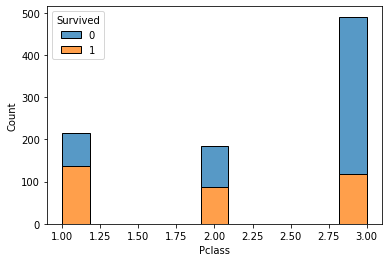

In [116]:
sns.histplot(data=df, x='Pclass', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Pclass')

Pclass seems to be a good indicator of survivorship, only needs OHE (or the same encoding but with one less column).

,female,male,Sum
0,81.000000,468.000000,549.000000
1,233.000000,109.000000,342.000000
%,74.203822,18.890815,38.383838


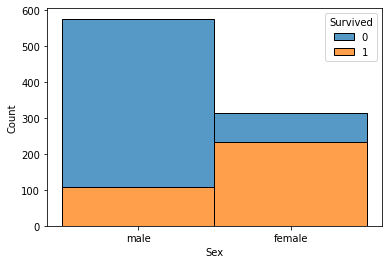

In [17]:
sns.histplot(data=df, x='Sex', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Sex')

Sex seems to be a very strong indicator of survivorship, all that's left to do is make it binary (ofc, only in this context).

,0,1,2,3,4,5,8,Sum
0,398.000000,97.000000,15.000000,12.0,15.000000,5.0,7.0,549.000000
1,210.000000,112.000000,13.000000,4.0,3.000000,0.0,0.0,342.000000
%,34.539474,53.588517,46.428571,25.0,16.666667,0.0,0.0,38.383838


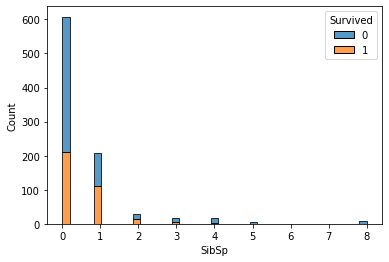

In [118]:
sns.histplot(data=df, x='SibSp', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'SibSp')

From this we gather that having 3 or more siblings/spouses(?) on board is likely to negatively affect your chances.  
Having 1 or 2 siblings/spouses on board is likely to positively affect your chances.  
And not having a spouse or sibling on board may negatively affect your chances slightly.  
In my opinion, the binary features "Has 1 or 2 SibSp" and "Has 3 or more SibSp" are worth exploring.

,0,1,2,3,4,5,6,Sum
0,445.000000,53.000000,40.0,2.0,4.0,4.0,1.0,549.000000
1,233.000000,65.000000,40.0,3.0,0.0,1.0,0.0,342.000000
%,34.365782,55.084746,50.0,60.0,0.0,20.0,0.0,38.383838


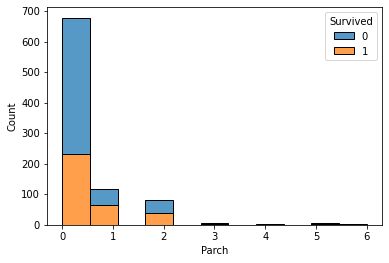

In [12]:
sns.histplot(data=df, x='Parch', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Parch')

I think that not having a child or a parent on-board doesn't actually matter.
<br>IMO all that 0 conveys is that you are not a child, which decreases your chances of survival.
<br>Notice that there's a sort of "Over-representation of children" in "parch" = 1. A family of 1 mother and 3 children will add 1 passenger with "parch" = 3, and 3 children with "parch" = 1. A similar thing happens in "parch" = 2 to a lesser degree.
<br>That's also why having a high "parch" means you'll probably die as you are an adult who's caring for a family.
<br>The survival rates you see here are merely a result of that "skew".
<br>The survival rate we should actually look at are of "Age" > 19 and "parch" > 0.

In [ ]:
# Add "parch" > 0 and "Age" > 19 stats here.

,0-10,11-18,18-21,21-24,24-26,26-29,29-31,31-35,35-39,39-45,45-54,54-80,Sum
0,36.000000,45.000000,55.000000,49.000000,48.000000,47.000000,47.000000,43.000000,48.000000,49.000000,46.000000,36.000000,549.000000
1,40.000000,31.000000,21.000000,27.000000,28.000000,29.000000,29.000000,33.000000,28.000000,27.000000,30.000000,19.000000,342.000000
%,52.631579,40.789474,27.631579,35.526316,36.842105,38.157895,38.157895,43.421053,36.842105,35.526316,39.473684,34.545455,38.383838


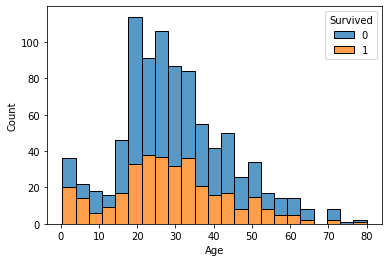

In [7]:
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack')

boundry = 10
binSize = (df.loc[df.Age <= boundry, 'Age'].size)

# Sort by age and then bin
sortAge = df.loc[:, ['Age', 'Survived']].sort_values(by=['Age'])
temp = sortAge.iloc[0:binSize, :]
pivotAge = pd.DataFrame(data=[binSize - temp.Survived.sum(), temp.Survived.sum()],
                        index=[0, 1], columns=[f'0-{int(round(boundry))}'])
for i in range(1, df.Age.size//binSize):
    temp = sortAge.iloc[i*binSize:(i+1)*binSize, :]
    low = int(round(sortAge.iloc[i*binSize, 0]))
    high = int(round(sortAge.iloc[(i+1)*binSize-1, 0]))
    pivotAge[f'{low}-{high}'] = [binSize -
                                 temp.Survived.sum(), temp.Survived.sum()]

temp = sortAge.iloc[(df.Age.size//binSize)*binSize:, :]
if not temp.empty:
    low = int(round(sortAge.iloc[(df.Age.size//binSize)*binSize, 0]))
    high = int(round(sortAge.iloc[-1, 0]))
    pivotAge[f'{low}-{high}'] = [temp.size/2 -
                                 temp.Survived.sum(), temp.Survived.sum()]

pivotAge['Sum'] = pd.Series(
    [pivotAge.iloc[0, :].sum(), pivotAge.iloc[1, :].sum()])
cols = pivotAge.columns.to_list()
pcents = []
for i in range(len(cols)):
    pcents.append(pivotAge.iloc[1, i]/pivotAge.iloc[:, i].sum() * 100)
pivotAge = pd.concat([pivotAge, pd.DataFrame(
    [pcents], columns=cols, index=['%'])])
pivotAge

Children have a high chance of surviving as children and women were rescued first.  
Teens probably preferential treatment.  
Young adults were left behind as they were the fittest.  
I am unsure why the 31-35 group survived more often. Maybe got 'unlucky' with filling in the missing data. 
Older folk have a lower chance of surviving, as expected.

,0-10,10-30,30-100,100+,Sum
0,269.000000,182.000000,84.00000,14.000000,549.000000
1,67.000000,139.000000,97.00000,39.000000,342.000000
%,19.940476,43.302181,53.59116,73.584906,38.383838


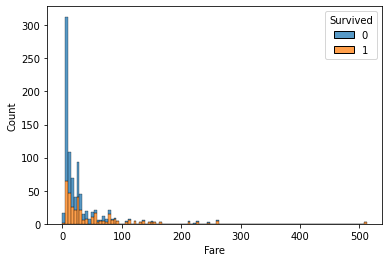

In [25]:
sns.histplot(data=df, x='Fare', hue='Survived', multiple='stack')

# I'll decide the ranges:
# 0-10
# 10-30
# 30-100
# 100+

col_1 = [df.loc[df.Fare <= 10, 'Survived'].size - df.loc[df.Fare <= 10, 'Survived'].sum(),
         df.loc[df.Fare <= 10, 'Survived'].sum()]
col_2 = [df.loc[df.Fare.between(10, 30, inclusive='right'), 'Survived'].size - df.loc[df.Fare.between(10, 30, inclusive='right'), 'Survived'].sum(),
         df.loc[df.Fare.between(10, 30, inclusive='right'), 'Survived'].sum()]
col_3 = [df.loc[df.Fare.between(30, 100, inclusive='right'), 'Survived'].size - df.loc[df.Fare.between(30, 100, inclusive='right'), 'Survived'].sum(),
         df.loc[df.Fare.between(30, 100, inclusive='right'), 'Survived'].sum()]
col_4 = [df.loc[100 < df.Fare, 'Survived'].size - df.loc[100 < df.Fare, 'Survived'].sum(),
         df.loc[100 < df.Fare, 'Survived'].sum()]
fareData = np.array([col_1, col_2, col_3, col_4]).T
pivotFare = pd.DataFrame(fareData, index=[0, 1], columns=[
                         '0-10', '10-30', '30-100', '100+'])

pivotFare['Sum'] = pd.Series(
    [pivotFare.iloc[0, :].sum(), pivotFare.iloc[1, :].sum()])
cols = pivotFare.columns.to_list()
pcents = []
for i in range(len(cols)):
    pcents.append(pivotFare.iloc[1, i]/pivotFare.iloc[:, i].sum() * 100)

pivotFare = pd.concat(
    [pivotFare, pd.DataFrame([pcents], columns=cols, index=['%'])])

pivotFare

As fares go up so do survival rates.  
From the 10-30 range you already have a higher chance of surviving, and at 100+ you are much more likely to survive.

,C,Q,S,Sum
0,75.000000,47.000000,427.000000,549.000000
1,93.000000,30.000000,217.000000,340.000000
%,55.357143,38.961039,33.695652,38.245219


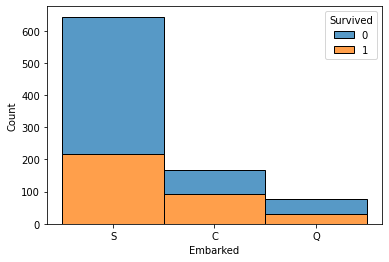

In [121]:
sns.histplot(data=df, x='Embarked', hue='Survived', multiple='stack')
# Notice the 'Sum' column, it shows there are 2 missing survivors.
PercentPivot(df, 'Survived', 'Embarked')

The 2 missing values are not catastrophic here and won't change the probabilities by a considerable amount.  

Departing from port Q seems to have little to no effect on survivorship.  
As a matter of fact, that's somewhat surprising, I wonder if this is to do with rich/poor distributions, young/old or female/male (I doubt it).  
Of course it may be that the distribution perfectly mirrors that of the ship.  

Departing from S seems to negatively affect survivorship. I'd guess that town is poorer.  

Departing from C seem to positively affect survivorship. I'd guess that town is more wealthy.

,Master,Miss,Mr.,Mrs.,Sum
0,17.0,55.00000,447.000000,30.00000,549.000000
1,23.0,130.00000,83.000000,104.00000,340.000000
%,57.5,70.27027,15.660377,77.61194,38.245219


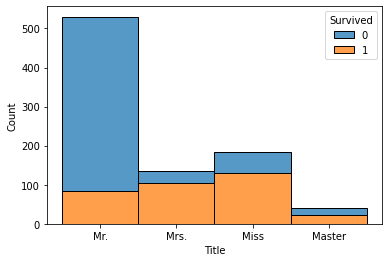

In [22]:
sns.histplot(data=df, x='Title', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Title')

Seems that a "Mrs." is more likely to survive than a "Miss". Perhaps because a "Mrs." has a husband who will fight for her or because she is more likely to have a child and be rescued with him.  
"Master" addresses a young man, children were rescued first and so "Master"s survived more often.

,A,B,C,D,E,F,G,T,U,Sum
0,8.000000,12.000000,24.000000,8.000000,8.0,5.000000,2.0,1.0,481.000000,549.000000
1,7.000000,35.000000,35.000000,25.000000,24.0,8.000000,2.0,0.0,206.000000,342.000000
%,46.666667,74.468085,59.322034,75.757576,75.0,61.538462,50.0,0.0,29.985444,38.383838


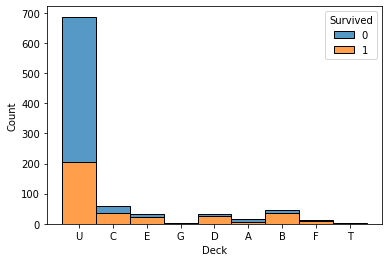

In [123]:
sns.histplot(data=df, x='Deck', hue='Survived', multiple='stack')
PercentPivot(df, 'Survived', 'Deck')

<font size=4>These cabin statistics are quite interesting.  
    Let's have a look at the [physical layout](https://en.wikipedia.org/wiki/First-class_facilities_of_the_Titanic) of the decks:</font> 
![title](Data/Olympic_&_Titanic_cutaway_diagram.png)
<br>I'll stay reserved in my analysis and say there's no difference between cabin decks, and that the differences we see are caused merely by a small dataset.
<br>I'd expect the lower decks to know of the crash sooner but have a harder time getting to the lifeboats, so it might cancel out.
<br>Since I'm uncertain whether the decks do have an effect or not, I'll add a "Has a cabin" feature, a OHE of the cabin data, and a "Upper Decks", "Lower Decks" feature and see which is the most important.

Port analysis:

In [ ]:
queensdale

### Major takeaways and features to add:

We'll handle different data types differently in our preprocessing.<br>
The pipelines help adding other transformers later and keeping things consistent.<br>
The binary columns don't need an imputer since they don't have any missing data in both datasets.

In [ ]:
Numerical_Pre = make_pipeline(SimpleImputer(strategy='mean'))
OneHot_Pre = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown = 'ignore'))

Col_Num = ['Age','Fare','SibSp','Parch']
Col_OHE = ['Sex','Deck','Title','Embarked','Pclass']


Preprocess = ColumnTransformer([('Col_OHE', OneHot_Pre, Col_OHE),
                                ('Col_Num', Numerical_Pre, Col_Num)
                                ])

In [ ]:
PreProOHE = [sorted([str(Col) + "_" + str(i) for i in df[Col].unique() if str(i) != 'nan']) for Col in Col_OHE]
Cols = PreProOHE + Col_Num
Cols